In [1]:
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="pastel")
import scipy
import json

from scipy import sparse

import time
import gc

In [2]:
data_dir = '2022-06-02'

In [3]:
papers = pd.read_csv(f'scibert_encoded_papers/valid_metadata_{data_dir}.csv',sep='\t').set_index('cord_uid')[['title','journal','publish_time']].sort_values('publish_time')

In [4]:
jrnls = Counter(papers['journal']).most_common(100)

In [35]:
# Counter(papers['journal']).most_common()

In [5]:
top_k = 10
selected =  list(map(lambda x:x[0], Counter(papers['journal']).most_common()[:top_k]))

In [37]:
# selected = ['Int J Environ Res Public Health','Front Public Health','Br J Surg','Front Immunol','Int J Mol Sci','J Clin Med']

In [6]:
for s in selected: print(s,Counter(papers['journal'])[s])

Int J Environ Res Public Health 5242
PLoS One 2954
Cureus 1908
Sci Rep 1898
Front Psychol 1815
BMJ Open 1672
Front Immunol 1402
Front Public Health 1377
Int J Mol Sci 1338
J Clin Med 1291


In [39]:
# n_per_class = 197

In [7]:
samples = []
for jrnl in selected:
    df = papers.loc[papers['journal']==jrnl] #.sample(n=n_per_class, random_state=0)
    samples.append(df)
samples = pd.concat(samples,axis=0)

In [8]:
samples['label'] = list(map(lambda x:selected.index(x),samples['journal'].tolist()))

In [9]:
Y = samples['label']

In [13]:
models_scores = dict()
for method in ['TF-IDF','Glove','SciBert','Biobert']:
    # method = 'scibert'
    # method = 'tfidf'
    # SCIBERT Embedding
    if method == 'SciBert':
        print('SciBert')
        title_embs_df = pd.read_csv(f'scibert_encoded_papers/title_embs_df_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'scibert_encoded_papers/abstract_embs_df_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    if method == 'Biobert':
        print('Biobert')
        title_embs_df = pd.read_csv(f'title_embs_df_biobert_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_biobert_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # Glove Embedding
    if method == 'Glove':
        print('Glove')
        title_embs_df = pd.read_csv(f'title_embs_df_glove_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_glove_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]


    # TF-IDF Embedding
    if method == 'TF-IDF':
        print('TF-IDF')
        values = scipy.sparse.load_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz')
        index = json.load(open(f"tf-idf-results/index_{data_dir}_scibert_token",'r',encoding='utf-8'))
        column = json.load(open(f"tf-idf-results/column_{data_dir}_scibert_token",'r',encoding='utf-8'))
        # paper_emb = pd.DataFrame.sparse.from_spmatrix(values,columns=column,index=index)
        uid_map = {uid:i for i,uid in enumerate(index)}
        X = values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
    

    clf = RandomForestClassifier()
    models_scores[method] = cross_validate(clf, X, Y, cv=5,
                             scoring=('f1_micro', 'f1_macro','neg_log_loss'),
                             return_train_score=True)

TF-IDF
Glove
SciBert
Biobert


In [14]:
data = []
for k,v in models_scores.items():
    for i in range(5):
        data.append([k,'Test Micro F1',v['test_f1_micro'][i]])
    for i in range(5):
        data.append([k,'Test Macro F1',v['test_f1_macro'][i]])
#     for i in range(5):
#         data.append([k,'test_neg_log_loss',v['test_neg_log_loss'][i]])

In [15]:
data_df = pd.DataFrame(data,columns=['method','metric','value'])

In [16]:
df = pd.concat([data_df.groupby(['method','metric']).apply(lambda x: x.mean()), data_df.groupby(['method','metric']).apply(lambda x: x.std())], axis=1)

In [17]:
df.columns = ['Mean', 'Std']

In [18]:
# top k :
df

Mean       Std
method  metric                           
Biobert Test Macro F1  0.492270  0.008157
        Test Micro F1  0.540030  0.002198
Glove   Test Macro F1  0.449052  0.003078
        Test Micro F1  0.497774  0.007505
SciBert Test Macro F1  0.499865  0.007657
        Test Micro F1  0.545246  0.006580
TF-IDF  Test Macro F1  0.439297  0.007619
        Test Micro F1  0.512944  0.004833

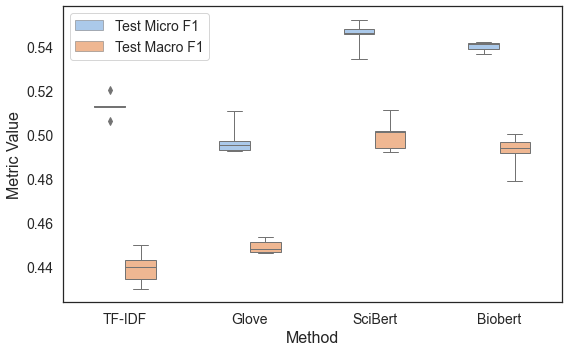

In [19]:
# Grouped violinplot
plt.figure(figsize=(8,5))
sns.boxplot(x='method', y='value',hue="metric", data=data_df, width=0.5, linewidth=1.,whis=8)
# sns.catplot(x='method', y='value',hue="metric", data=data_df, linewidth=1,height=4, aspect=.7, palette="Set3")
# sns.swarmplot(x='method', y='value',hue="metric", data=data_df,palette="Blues")

plt.legend(loc='upper left',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Metric Value',fontsize=16)
plt.xlabel('Method',fontsize=16)
# plt.show()
plt.tight_layout()
plt.savefig('Jrnl_Classification.png',dpi=300)

In [28]:
df

Mean       Std
method  metric                           
Glove   Test Macro F1  0.613423  0.027470
        Test Micro F1  0.716974  0.011954
SciBert Test Macro F1  0.632459  0.017395
        Test Micro F1  0.730987  0.006856
TF-IDF  Test Macro F1  0.573969  0.017924
        Test Micro F1  0.700655  0.005800

In [32]:
df.round(4).to_excel('jrnl_clf.xlsx')

In [14]:
# iris_df = sns.load_dataset('iris')

In [28]:
# data_df

In [15]:
# iris_df

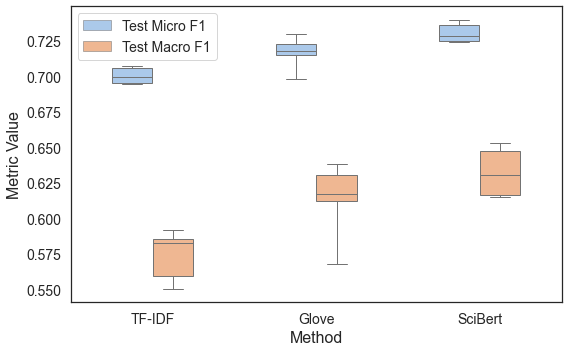

In [29]:
# Grouped violinplot
plt.figure(figsize=(8,5))
sns.boxplot(x='method', y='value',hue="metric", data=data_df, width=0.5, linewidth=1.,whis=8)
# sns.catplot(x='method', y='value',hue="metric", data=data_df, linewidth=1,height=4, aspect=.7, palette="Set3")
# sns.swarmplot(x='method', y='value',hue="metric", data=data_df,palette="Blues")

plt.legend(loc='upper left',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Metric Value',fontsize=16)
plt.xlabel('Method',fontsize=16)
# plt.show()
plt.tight_layout()
plt.savefig('Jrnl_Classification.png',dpi=300)

In [17]:
# scores

In [31]:
# print(scores['test_f1_micro'])
# print(scores['test_f1_macro'])
# print(scores['test_neg_log_loss'])